
### Weather observations from Synoptic Weather 
Here, we demonstrate functions that download observation data from Synoptic Weather using the package `synopticpy`.

Our aim is to create straightforward API calls to download weather data for given radius, variables, times, etc. 

We should demonstrate visualizations of the data, both as a sanity check and for reports/publications.

Also:
* Show representative observation creation 
* More...

In [126]:
import os 
import datetime
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from obs.obsdata import ObsData


In [127]:
def visualize_station_locations(meta_df, towns, extent, only_stids=None, stid_name=False):
    """
    Visualize station locations on a map.

    Args:
        meta_df (pd.DataFrame): Metadata dataframe containing station information.
        towns (dict): Dictionary of towns with their coordinates.
        extent (list): List of extents for the map [west, east, south, north].
        only_stids (list, optional): List of station IDs to plot. If None, plot all stations.
        stid_name (bool, optional): Annotate the stid string by each scatter point. Default is False.

    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())

    lats = []
    lons = []
    elevs = []
    stids = []

    for stid in meta_df.columns:
        if only_stids is None or stid in only_stids:
            # Convert to meters
            elevs.append(meta_df[stid].loc["ELEV_DEM"] * 0.304)
            lats.append(meta_df[stid].loc["latitude"])
            lons.append(meta_df[stid].loc["longitude"])
            stids.append(stid)

    sc = ax.scatter(lons, lats, c=elevs, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(sc)

    # Annotate stid string by each scatter point if stid_name is True
    if stid_name:
        for lon, lat, stid in zip(lons, lats, stids):
            ax.text(lon, lat, stid, transform=ccrs.PlateCarree(), fontsize=8)

    # Add reference towns in RED
    for town, latlon in towns.items():
        ax.scatter(latlon[1], latlon[0], color='red', transform=ccrs.PlateCarree())
        ax.text(latlon[1], latlon[0], town, color='red', transform=ccrs.PlateCarree())

    ax.add_feature(cfeature.STATES.with_scale("10m"))
    ax.add_feature(cfeature.RIVERS.with_scale("10m"))

    ax.set_extent(extent)  # set extents
    plt.show()

In [128]:

def plot_variable_by_years(data_path, common_stids, years, vrbl):
    """
    Plot the variable by day of the year for each year, overlaying the lines for each winter season.

    Args:
        data_path (str): Path to the data files.
        common_stids (set): Set of common station IDs.
        years (list): List of years to plot.
        vrbl (str): Variable name to plot.

    Returns:
        None
    """
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    plot_years = years[-5:]

    for i, stid in enumerate(common_stids):
        row = i // 3
        col = i % 3
        ax[row, col].set_title(stid)
        # ax[row, col].set_ylim(-10, 10)
        # Each "year" actually goes across two calendar years, so x-axis is 1 Dec to 31 March
        # The year is the February year of that particular subset

        for year in plot_years:
            df, meta_df = ObsData.load_dfs(data_path, f"UB_obs_{year}.parquet")
            df = df[df["stid"] == stid]
        
            # Filter to include only November to March
            df = df[(df.index.month >= 11) | (df.index.month <= 3)]
        
            df[vrbl].plot(ax=ax[row, col], label=year)
            
        # for a in ax.flat:
        #     a.set_xlim([pd.Timestamp('2000-11-01'), pd.Timestamp('2001-03-31')])

    # Add legend outside the plot
    fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.tight_layout()
    plt.show()


First section is commented out because we have already downloaded data using `download_gather_winters.py` script in the `obs` directory. It is kept to show the nature of the raw data and what was done to get to the ObsData class. 

In [129]:
# obs_end_dt = datetime.datetime(2023,3,15,0,0,0)
# obs_start_dt = obs_end_dt - datetime.timedelta(hours=72)

# radius is 45 in v0.1 but could be bigger to capture pseudo-lapse-rate better (temperature observations up the slope)
# Uses Pelican Lake as centre point, default (UCL21)

# obs = ObsData(obs_start_dt, obs_end_dt, radius_mi=50,)
# print("Obs loaded")
# obs.df.head(10)

The data has idiosyncracies like variable names containing "set" and "value". Note our metadata for each winter's forecast data is kept in a sister file (pickle, not parquet) denoted by the `_meta` suffix. 

In [130]:
# obs.df.columns[obs.df.columns.str.contains("_set_")]

In [131]:
# obs.df.columns[obs.df.columns.str.contains("_value_")]


In [132]:
# For each _set_ column, count how many non-NaNs appear out of the total number of rows
# for col in obs.df.columns[obs.df.columns.str.contains("_set_")]:
#     print(f"{col}: {obs.df[col].count()} / {obs.df.shape[0]}")
    

In [133]:
# At the time of the first non-NaN value for each of the columns above, show what the
# value for the station is for the variable named the same up to the "_set_*" suffix
# where * can be various things like 1, 1d, etc

# "re" is to do with regex I think, to search more finely for the variable name

# for col in obs.df.columns[obs.df.columns.str.contains("_set_")]:
#     first_non_nan = obs.df[col].first_valid_index()
#     print(f"{col} first non-NaN: {first_non_nan}")
#     if first_non_nan:
#         print(obs.df.loc[first_non_nan, col])
#         print(obs.df.loc[first_non_nan, re.sub(r'_set_.*', '', col)])
#         print("\n"*3)

In [134]:
# obs.df.dtypes

That was the dataframe for real data for our variables of interest. This is the metadata that contains information about each station we look up by station name (`stid`; the column name). Things like elevation, latitude, longitude, etc., which is useful for plotting.

In [135]:
# obs.meta_df

In [136]:
# obs.meta_df.dtypes

In [137]:
# This is the old instance and we don't want to accidentally use if continuing / uncommented
# del obs

## Start here for loading the data and exploring per winter

In [138]:
# Test to look at example of the data
df, meta_df = ObsData.load_dfs("../data", "UB_obs_2016.parquet")
df.head(10)

,air_temp,altimeter,ceiling,dew_point_temperature_set_1,dew_point_temperature,pressure,sea_level_pressure_set_1,sea_level_pressure,wind_direction,wind_speed,...,wind_v,stid,snow_depth,snow_smoothed,snow_water_equiv,solar_radiation,soil_temp,soil_temp_set_5,PM_25_concentration,ozone_concentration
date_time,,,,,,,,,,,,,,,,,,,,,
2015-12-01 00:53:00+00:00,-7.2,101930.250000,NaN,-11.700000,-11.770000,83973.273438,102450.0,102776.968750,360.0,2.06,...,-2.060,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 01:53:00+00:00,-10.0,101930.250000,NaN,-12.800000,-12.850000,83973.273438,102540.0,102993.906250,280.0,2.06,...,-0.358,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 02:53:00+00:00,-11.1,101997.976562,NaN,-13.900000,-13.950000,84029.070312,102620.0,103149.007812,290.0,3.09,...,-1.057,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 03:53:00+00:00,-11.7,102065.703125,NaN,-15.000000,-15.060000,84084.859375,102690.0,103265.140625,0.0,0.00,...,0.000,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 04:53:00+00:00,-12.8,102133.429688,NaN,-15.600000,-15.650000,84140.656250,102730.0,103421.671875,260.0,3.09,...,0.537,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 05:53:00+00:00,-13.3,102167.296875,NaN,-16.100000,-16.150000,84168.562500,102810.0,103496.242188,280.0,2.57,...,-0.446,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 06:53:00+00:00,-13.3,102167.296875,NaN,-16.100000,-16.150000,84168.562500,102820.0,103496.242188,280.0,2.06,...,-0.358,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 07:53:00+00:00,-13.9,102167.296875,NaN,-17.200001,-17.260000,84168.562500,102790.0,103544.812500,280.0,2.06,...,-0.358,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 08:53:00+00:00,-14.4,102133.429688,NaN,-17.799999,-17.860001,84140.656250,102780.0,103551.132812,280.0,2.06,...,-0.358,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
meta_df

,KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,...,4276P,PC266,PC353,UB1UT,PC486,UGSDV,UTELP,UTMTH,PC558,PC561
DISTANCE,20.26,22.29,40.84,32.16,39.04,37.87,37.27,42.98,34.35,21.18,...,26.36,25.48,16.98,15.51,29.22,15.57,17.01,40.08,23.64,30.35
ELEVATION,5262.0,5151.0,5725.0,9552.0,9448.0,7730.0,7484.0,6722.0,6469.0,5240.0,...,4803.0,8426.0,5947.0,5070.0,6149.0,5032.0,5692.0,6695.0,5818.0,5364.0
ELEV_DEM,5269.0,5200.1,5590.6,9583.3,9471.8,7729.7,7483.6,6702.8,6423.9,5226.4,...,NaN,8441.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,61,878,902,1494,1509,2336,2337,2348,2360,2365,...,173578,175633,217351,237823,238714,239856,243538,245316,245317,245375
MNET_ID,1,1005,19,25,25,2,2,2,2,2,...,208,247,247,153,247,153,4,4,247,247
NAME,Vernal Airport,ROOSEVELT-UNION HS,STARVATION DAM,MOSBY MTN.,TROUT CREEK,DIAMOND RIM,FIVE MILE,MCCOOK RIDGE,UPPER SAND WASH,YAMPA PLATEAU,...,Dino Ozone Station,Little Mountain,Vernal West,CIGE 226,Little Valley,Desert View (Myton) EC,SR-121 at MP 31.5 East Lapoint,SR-87 at MP 16 Mountain Home,Ashley,Duchesne River
RECORD_END,2024-10-10 07:55:00+00:00,2002-02-13 21:00:00+00:00,NaT,2024-10-10 07:00:00+00:00,2024-10-10 07:00:00+00:00,2024-10-10 07:27:00+00:00,2024-10-10 07:28:00+00:00,2024-10-10 07:27:00+00:00,2024-10-10 07:27:00+00:00,2024-10-10 07:27:00+00:00,...,2022-05-27 03:10:00+00:00,2024-10-10 08:10:00+00:00,2024-10-10 08:10:00+00:00,2024-10-10 07:15:00+00:00,2024-10-10 08:10:00+00:00,2024-10-10 08:00:00+00:00,2024-10-10 08:00:00+00:00,2024-10-10 08:00:00+00:00,2024-10-10 08:10:00+00:00,2024-10-10 08:10:00+00:00
RECORD_START,1997-01-01 00:00:00+00:00,1999-01-12 00:00:00+00:00,NaT,2000-01-20 00:00:00+00:00,2000-01-20 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-05-27 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-01-01 00:00:00+00:00,...,2022-04-26 21:10:00+00:00,2022-06-30 20:15:00+00:00,2023-05-16 08:14:00+00:00,2024-05-13 18:00:00+00:00,2024-06-11 07:40:00+00:00,2024-07-12 19:30:00+00:00,2024-08-23 00:40:00+00:00,2024-09-26 20:40:00+00:00,2024-09-27 07:40:00+00:00,2024-10-03 07:30:00+00:00
RESTRICTED,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
STATE,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT


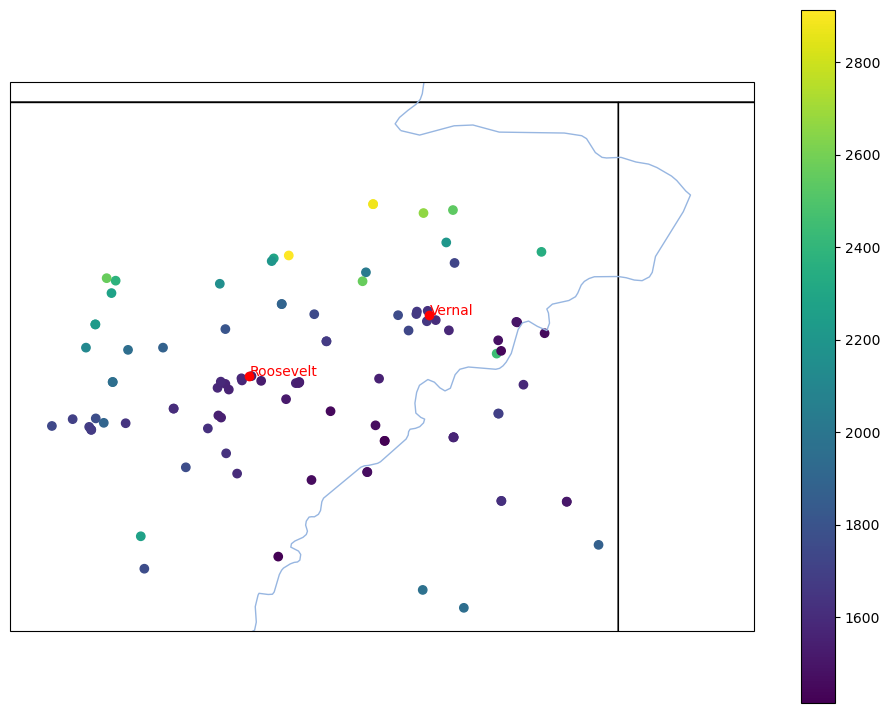

In [140]:

towns = {
    "Vernal": [40.4555, -109.5287],
    "Roosevelt": [40.2994, -109.9888],
}
extent = [-110.6, -108.7, 39.65, 41.05]

# Assuming meta_df is already defined
visualize_station_locations(meta_df, towns, extent)

In [141]:
# Subset df to columns containing "soil_temp".
soil_temp_cols = df.columns[df.columns.str.contains("soil_temp")]
soil_df = df[soil_temp_cols].dropna(how='all')
soil_df

,soil_temp,soil_temp_set_5
date_time,,
2015-12-01 00:00:00+00:00,2.26,NaN
2015-12-01 00:10:00+00:00,2.27,NaN
2015-12-01 00:20:00+00:00,2.27,NaN
2015-12-01 00:30:00+00:00,2.26,NaN
2015-12-01 00:40:00+00:00,2.26,NaN
...,...,...
2016-03-14 23:20:00+00:00,5.99,NaN
2016-03-14 23:30:00+00:00,6.00,NaN
2016-03-14 23:40:00+00:00,6.01,NaN


In [142]:
soil_df.describe()    

,soil_temp,soil_temp_set_5
count,44262.000000,651.000000
mean,0.213714,-0.288018
std,2.406811,0.853569
min,-3.410000,-2.220000
25%,-1.730000,0.040000
50%,0.070000,0.090000
75%,1.190000,0.110000
max,6.320000,0.140000


### Tests for soil temperature: is there a relationship between snowfall and soil temperature, considering all years?
A warmer ground on Dec 1 may mean longer predictability for whether snow persists. 

In [143]:
# CONSTANTS
years = np.arange(2005,2025)


In [144]:

def load_data_for_years(data_path, years, vrbl):
    """
    Load data for each year and count the number of unique stations that report at least one non-NaN for the given variable.

    Args:
        data_path (str): Path to the data files.
        years (list): List of years to load data for.
        vrbl (str): Variable name to check for non-NaN values.

    Returns:
        pd.DataFrame: DataFrame with counts of unique stations per year and their IDs.
    """
    year_counts = {}
    vrbl_stids = {}

    for year in years:
        df, meta_df = ObsData.load_dfs(data_path, f"UB_obs_{year}.parquet")
        
        try:
            small_df = df[[vrbl, "stid"]]
            year_counts[year] = small_df[small_df[vrbl].notnull()]["stid"].nunique()
            vrbl_stids[year] = small_df[small_df[vrbl].notnull()]["stid"].unique()
        except KeyError:
            print(f"Data for {year} not found")
            year_counts[year] = 0
            vrbl_stids[year] = []
            continue

    year_counts_df = pd.DataFrame.from_dict(year_counts, orient='index', columns=["stids"])
    stid_string_col = [",".join(vrbl_stids[year]) if len(vrbl_stids[year]) else "" for year in years]
    year_counts_df["stid_string"] = stid_string_col

    return year_counts_df

def find_common_stids(vrbl_stids, years, num_years):
    """
    Find the station IDs that have reported for the last `num_years` consistently.

    Args:
        vrbl_stids (dict): Dictionary of station IDs per year.
        years (list): List of years.
        num_years (int): Number of years to check for consistency.

    Returns:
        set: Set of common station IDs.
    """
    stids = [set(vrbl_stids[year]) for year in years[-num_years:]]
    return set.intersection(*stids)

data_path = "../data"
vrbl = "soil_temp"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_stids = find_common_stids(vrbl_stids, years, 5)
print(len(common_stids))
common_stids

Data for 2005 not found
      stids                                        stid_string
2005      0                                                   
2006      2                                        USWU1,SFLU1
2007      2                                        USWU1,SFLU1
2008     85  USWU1,SFLU1,MHMU1,AT569,A1388,A1633,A1622,A138...
2009     86  USWU1,SFLU1,UTSTV,MHMU1,AT569,A1388,A1633,A162...
2010     86  USWU1,SFLU1,UTSTV,MHMU1,AT569,A1388,A1633,A162...
2011      5                      USWU1,SFLU1,UTSTV,AS290,WAXU1
2012      5                      USWU1,SFLU1,UTSTV,AS290,WAXU1
2013      5                      USWU1,SFLU1,UTSTV,AS290,WAXU1
2014      5                      USWU1,SFLU1,UTSTV,AS290,WAXU1
2015      3                                  UTSTV,AS290,WAXU1
2016      3                                  UTSTV,AS290,WAXU1
2017      4                            UTSTV,AS290,WAXU1,UCC33
2018      9  UTSTV,AS290,WAXU1,MHMU1,AT569,SPMU1,LRFU1,UCC3...
2019      9  UTSTV,AS290,WAXU1,

{'AS290',
 'AT569',
 'LRFU1',
 'MHMU1',
 'SPMU1',
 'UCC33',
 'UCC34',
 'UTSTV',
 'WAXU1'}

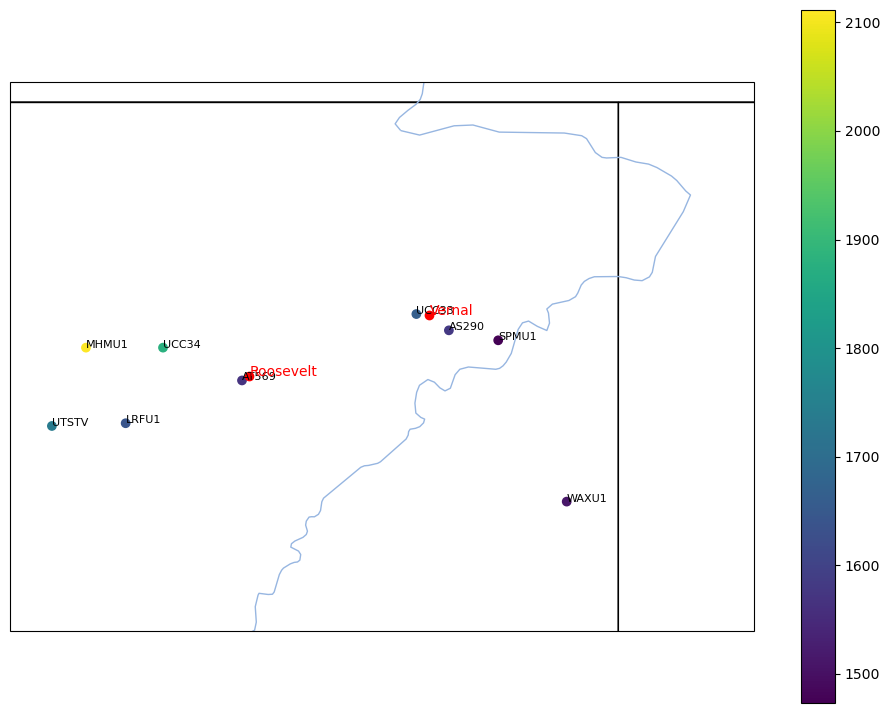

In [145]:
# Plot these common stids on a map, labelled.
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_stids), stid_name=True)


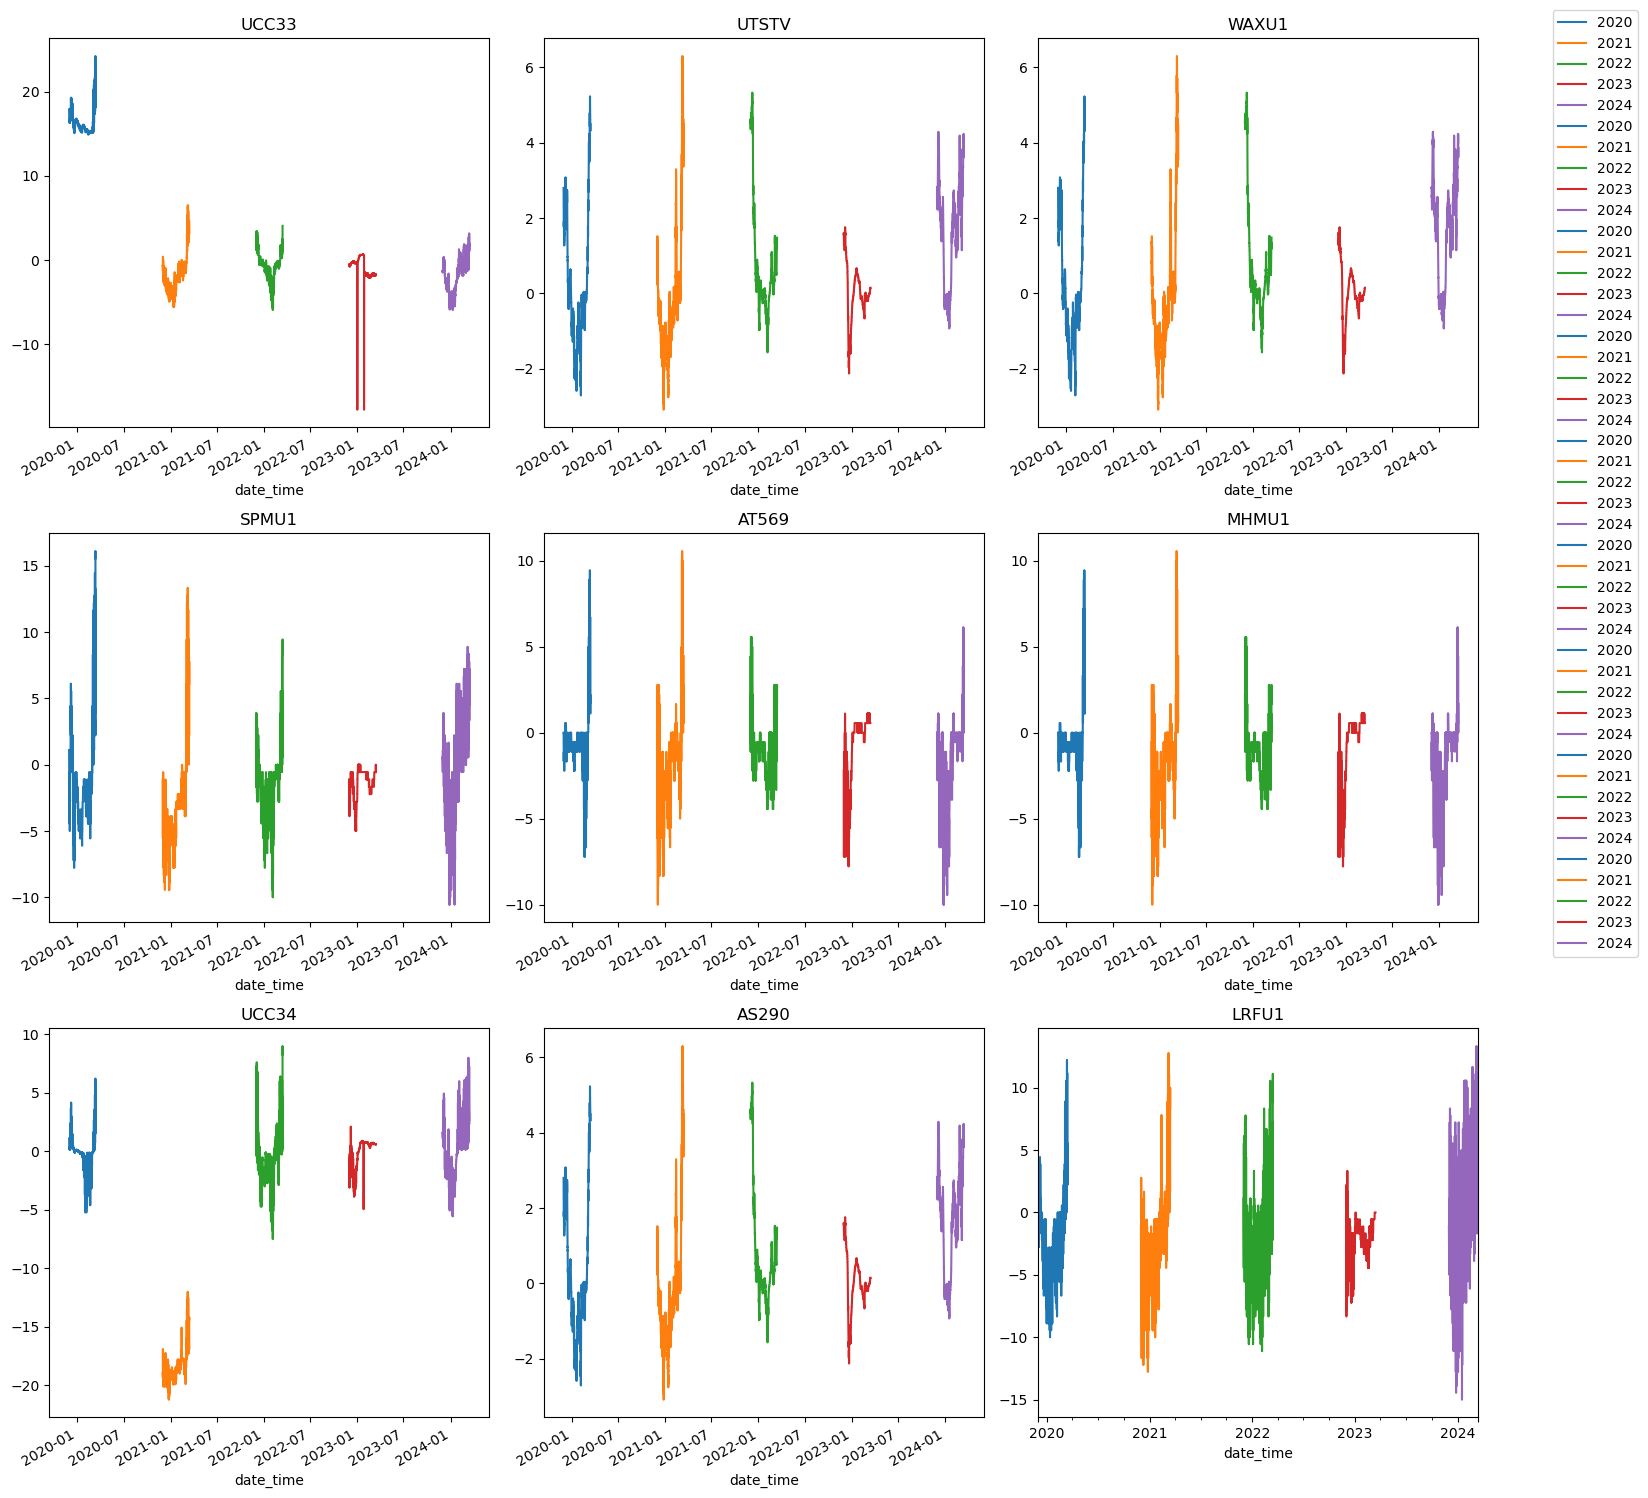

In [146]:
plot_variable_by_years(data_path, common_stids, years[-5:], vrbl)


In [147]:
vrbl = "ozone_concentration"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_stids = find_common_stids(vrbl_stids, years, 9)
print(len(common_stids))
common_stids

Data for 2005 not found
Data for 2006 not found
Data for 2007 not found
Data for 2008 not found
Data for 2009 not found
Data for 2010 not found
Data for 2011 not found
Data for 2012 not found
Data for 2013 not found
Data for 2014 not found
      stids                                        stid_string
2005      0                                                   
2006      0                                                   
2007      0                                                   
2008      0                                                   
2009      0                                                   
2010      0                                                   
2011      0                                                   
2012      0                                                   
2013      0                                                   
2014      0                                                   
2015      0                                                   
2016

{'A3822',
 'QRS',
 'QV4',
 'UBHSP',
 'UBMYT',
 'UBORY',
 'UBRBM',
 'UBRDW',
 'UBWHR',
 'UUT01'}

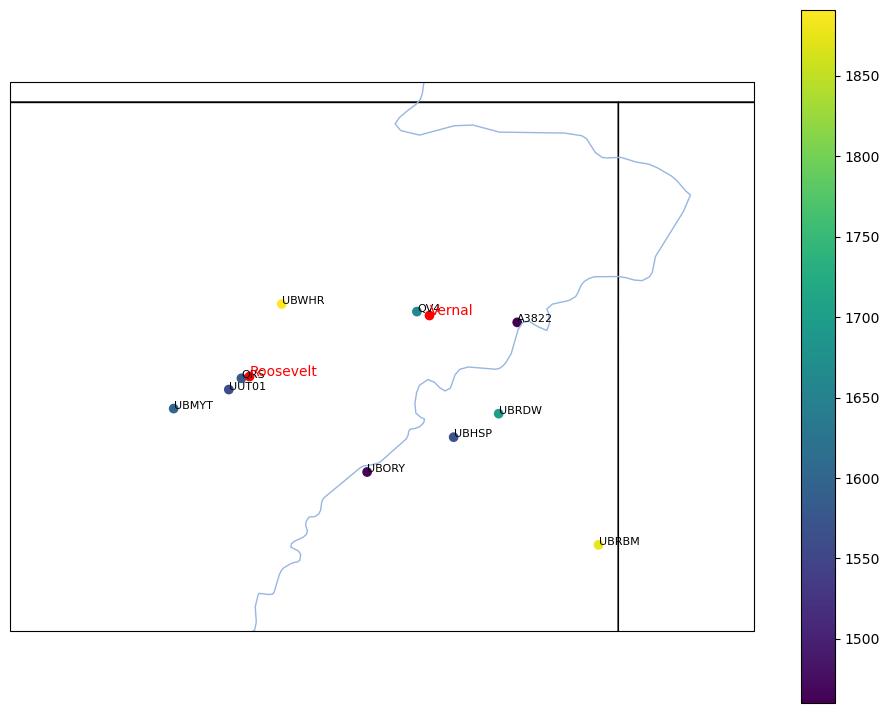

In [148]:
# Plot these common stids on a map, labelled.
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_stids), stid_name=True)


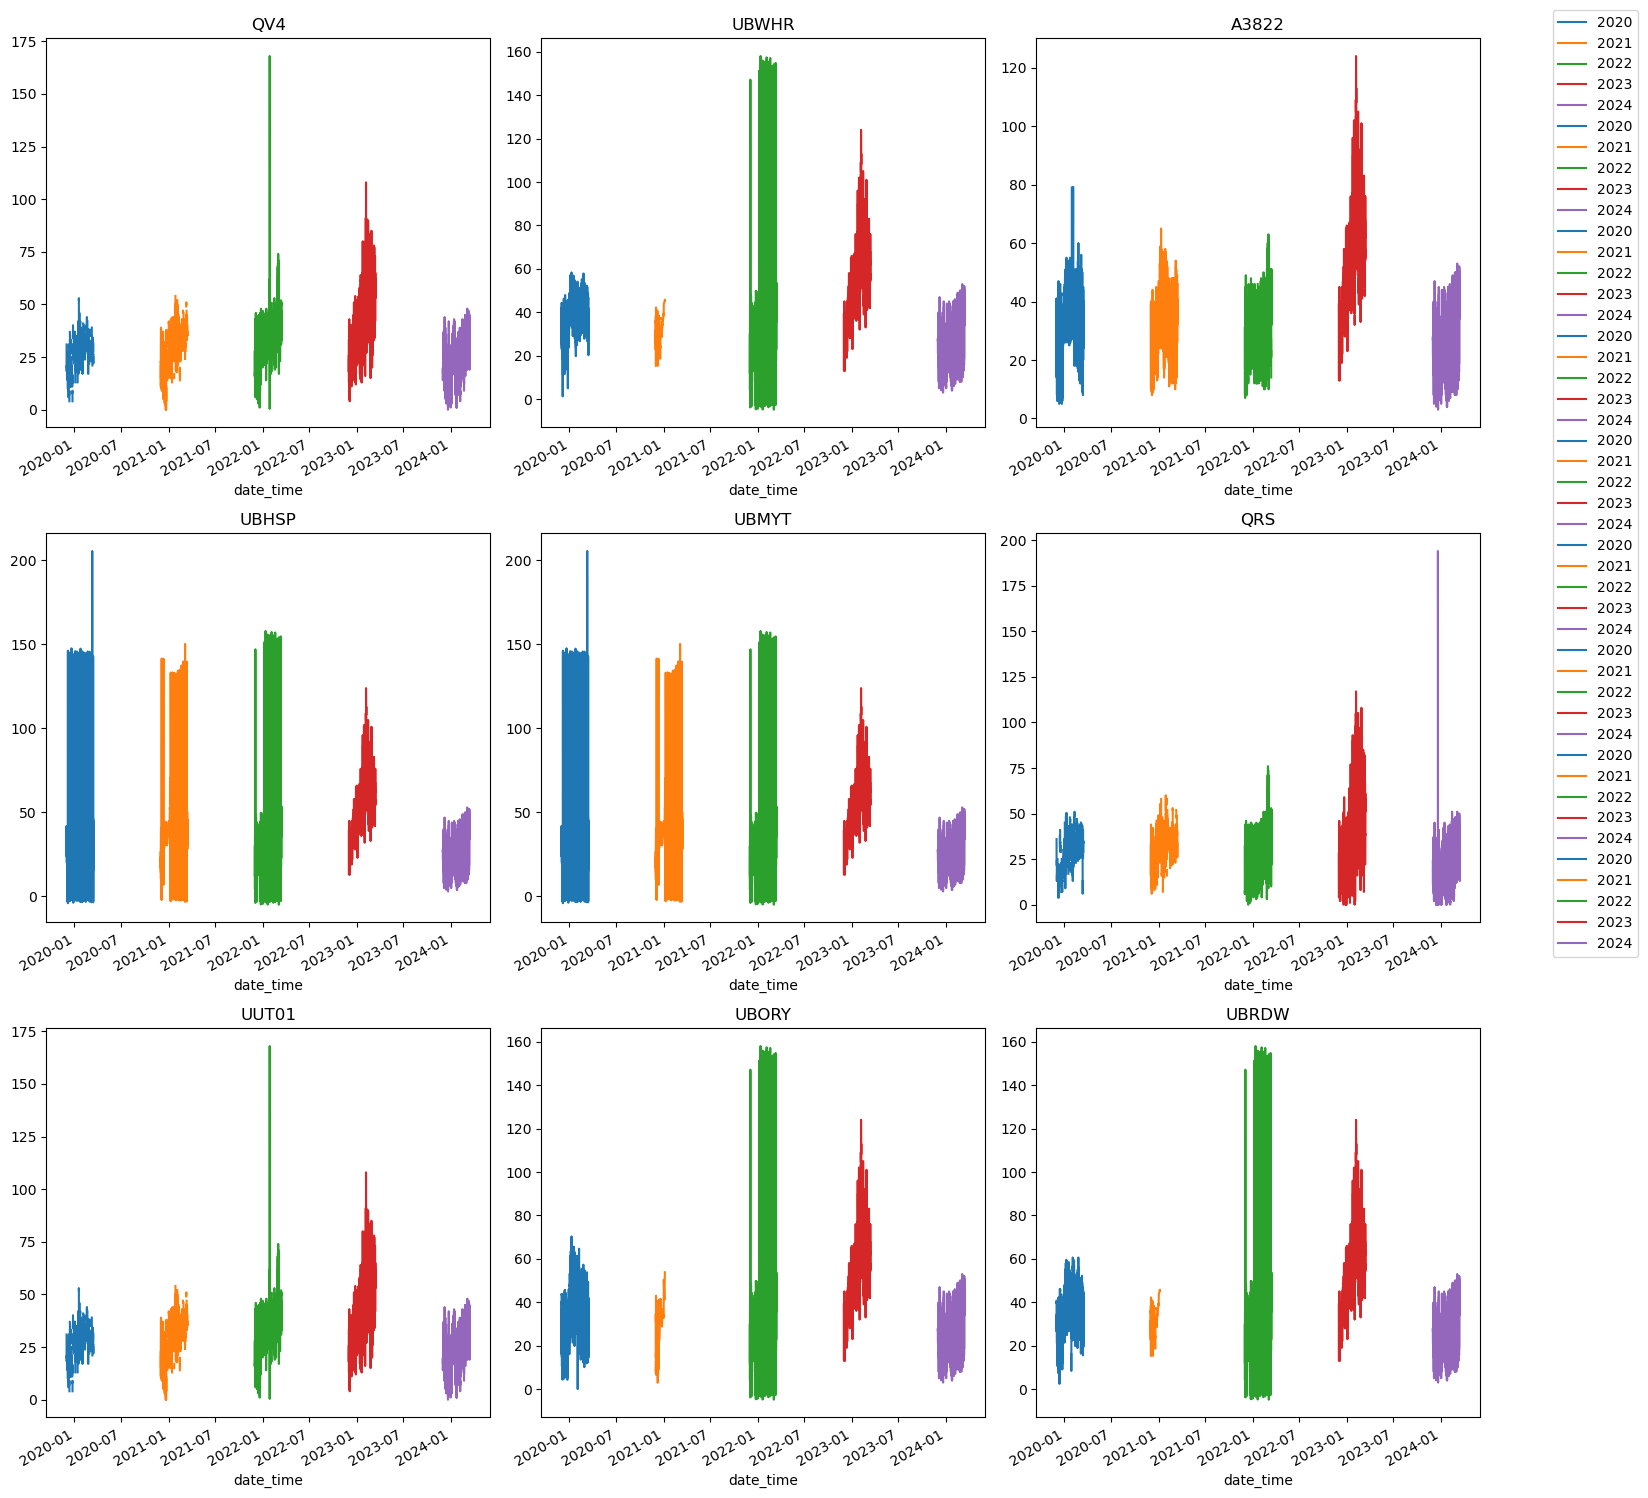

In [149]:
ozone_stids = [stid for stid in common_stids if "UBRB" not in stid]
plot_variable_by_years(data_path, ozone_stids, years[-5:], "ozone_concentration")


In [ ]:
# We need to see daily maxima of ozone (local midnight, UTC-6) shown as the 3 x 3 plot.

In [ ]:
# need to look at longest time series and isolate events and their length 

In [150]:
vrbl = "snow_depth"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_stids = find_common_stids(vrbl_stids, years, 8)
print(len(common_stids))
common_stids

      stids                                        stid_string
2005      3                                  MMTU1,TCKU1,KGCU1
2006      3                                  MMTU1,TCKU1,KGCU1
2007      3                                  MMTU1,TCKU1,KGCU1
2008      3                                  MMTU1,TCKU1,KGCU1
2009      3                                  MMTU1,TCKU1,KGCU1
2010      3                                  MMTU1,TCKU1,KGCU1
2011      3                                  MMTU1,TCKU1,KGCU1
2012      4                            MMTU1,TCKU1,KGCU1,LFKU1
2013      4                            MMTU1,TCKU1,KGCU1,LFKU1
2014      4                            MMTU1,TCKU1,KGCU1,LFKU1
2015      4                            MMTU1,TCKU1,KGCU1,LFKU1
2016      6                MMTU1,TCKU1,KGCU1,LFKU1,TRZO3,UBHSP
2017     15  MMTU1,TCKU1,KGCU1,LFKU1,TRZO3,UBHSP,COOPALMU1,...
2018     17  MMTU1,TCKU1,KGCU1,LFKU1,TRZO3,UBHSP,UBMTH,COOP...
2019     35  MMTU1,TCKU1,KGCU1,LFKU1,UBHSP,UBMTH,UBMYT,

{'COOPALMU1',
 'COOPDINU1',
 'COOPDSNU1',
 'COOPFTDU1',
 'COOPJENU1',
 'COOPNELU1',
 'COOPOURU1',
 'COOPROSU1',
 'COOPVELU1',
 'KGCU1',
 'LFKU1',
 'MMTU1',
 'TCKU1'}

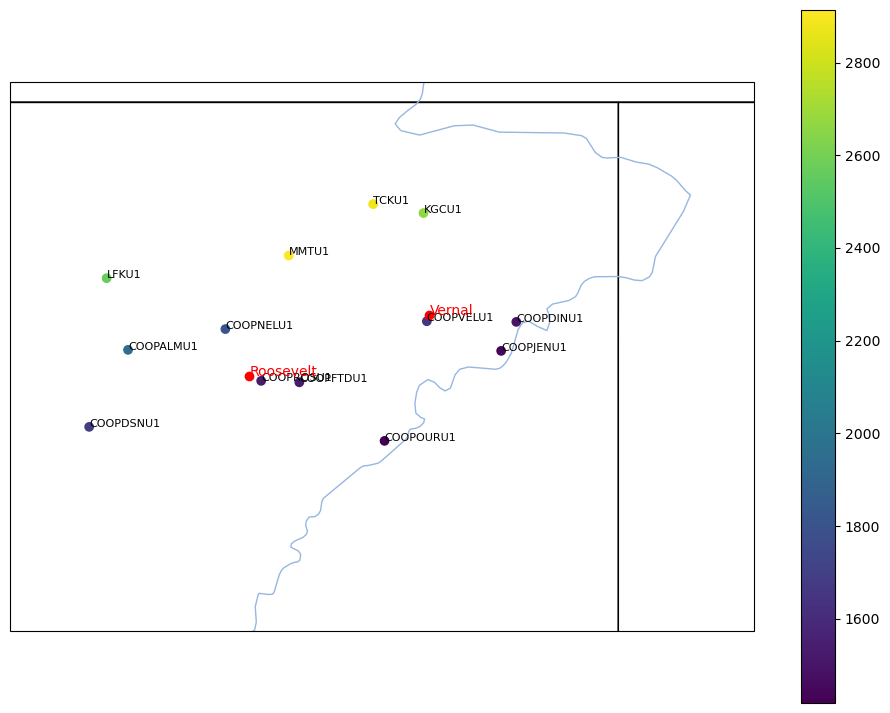

In [151]:
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_stids), stid_name=True)


In [152]:
snow_stids = [stid for stid in common_stids if "COOP" in stid]
snow_stids

['COOPDSNU1',
 'COOPOURU1',
 'COOPROSU1',
 'COOPFTDU1',
 'COOPDINU1',
 'COOPJENU1',
 'COOPNELU1',
 'COOPALMU1',
 'COOPVELU1']

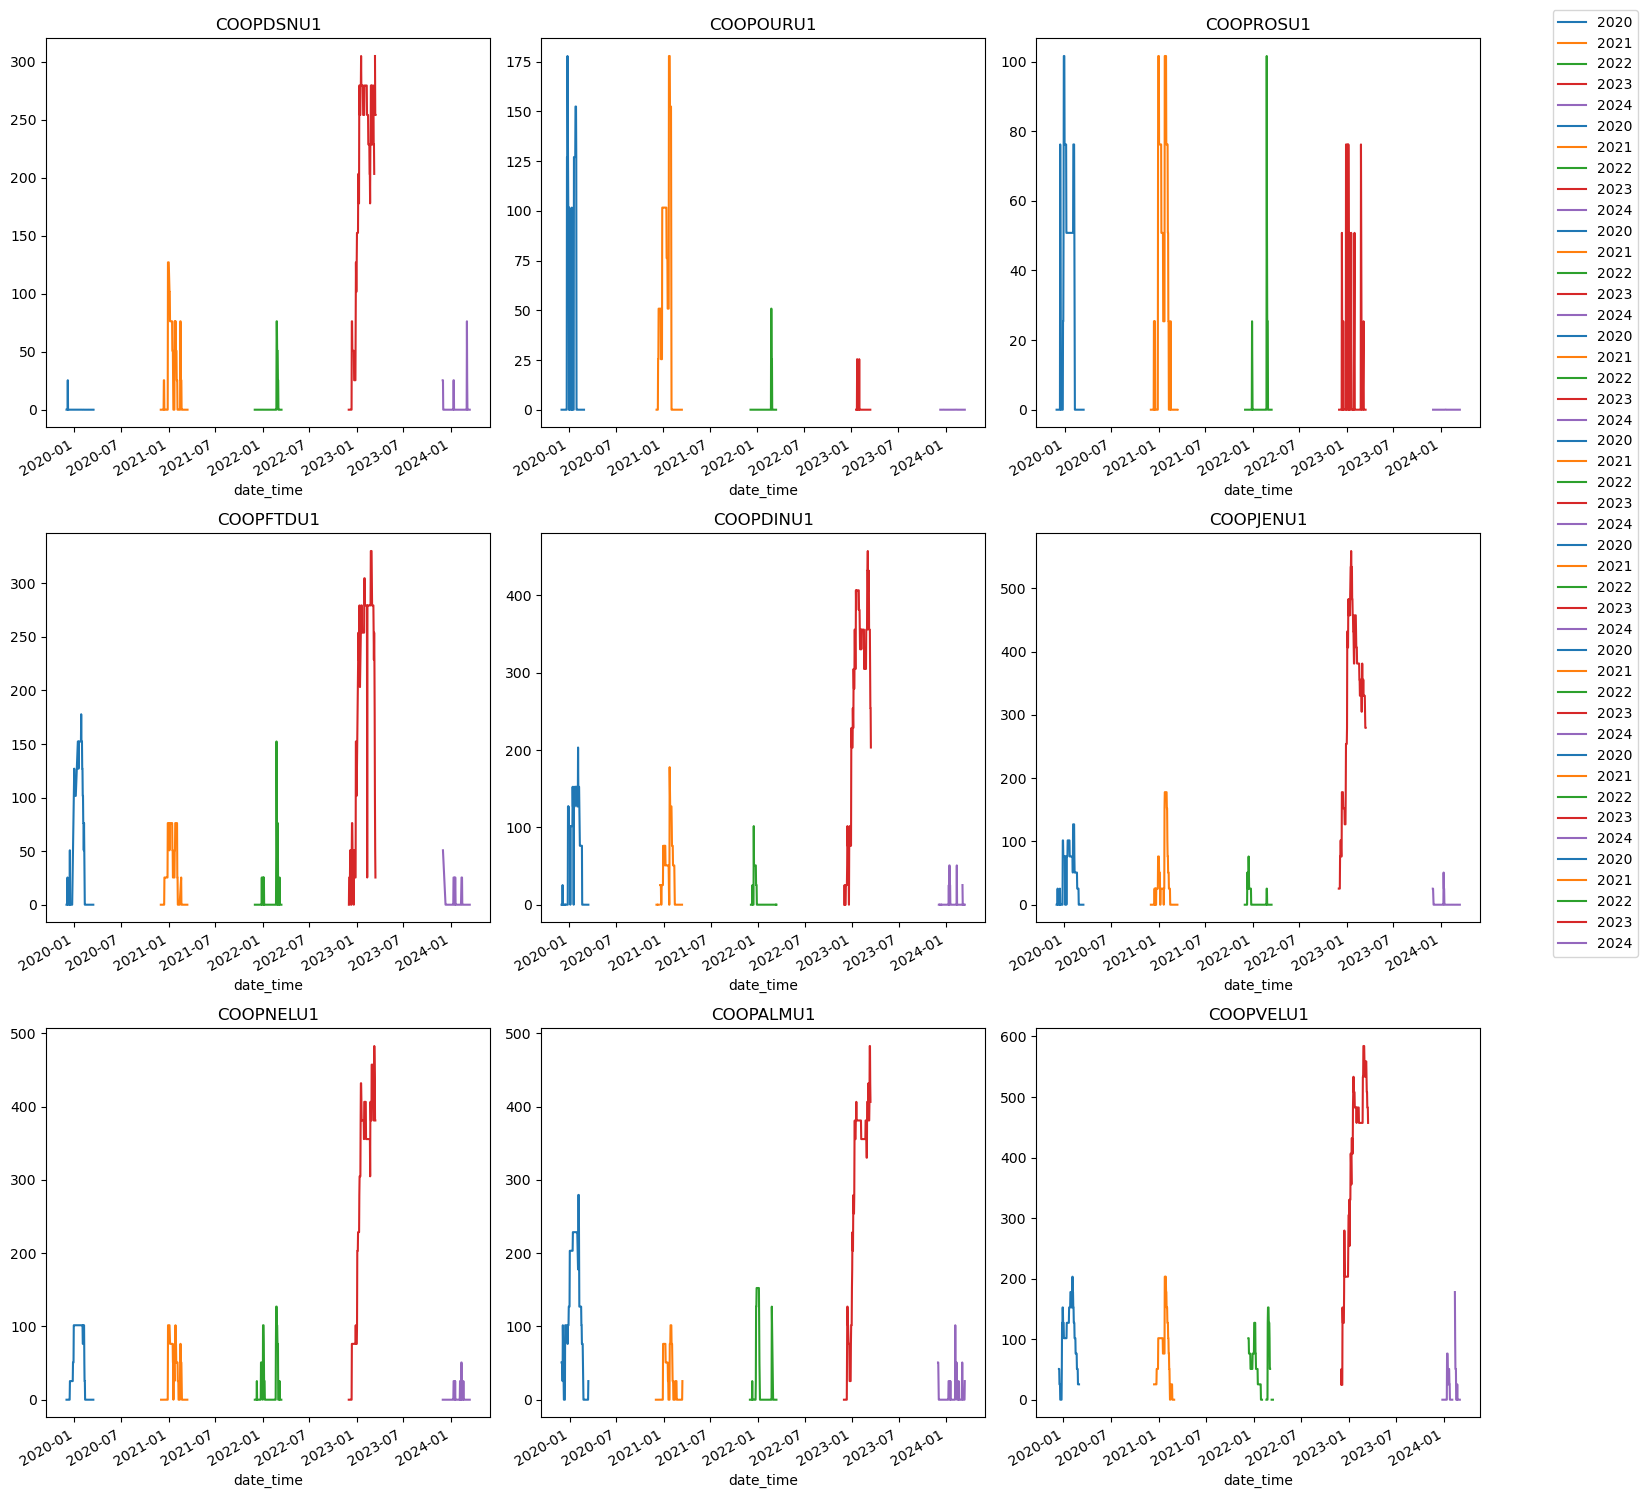

In [153]:
# Now visualise with the plot of 3x3 stations for snow depth 
plot_variable_by_years(data_path, snow_stids, years[-8:], vrbl)

In [154]:
# Can we find dates where snow depth was > 50mm, and see snow depth, ozone concentration, and soil temperature time series for those dates?

### Pseudo lapse rate
We can estimate a lapse rate of temperature using the variation of observed temperature with elevation, meaning we can use the station's altitude to compute potential temperature and therefore stability and presence of inversions.

In [155]:
# Try some code I've written before here 

### Case studies 
We should identify longer periods of one continuous cold pool / ozone event in the five years we have good soil temperature data.
We want to look at pseudo-lapse-rate estimates and soil temperature in the Basin and whether they have predictive power for the FIS in Clyfar.

A catalogue of events would show the life cycle of the cold pool and high-ozone event: useful for the paper and FIS configuration.

In [156]:
# Identify stations to use for historical ozone measurements 